# SpecParam

This notebook measures aperiodic activity using the 'spectral parameterization' algorithm.

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import numpy as np

In [3]:
from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import set_random_seed
from fooof import FOOOF

In [4]:
# Import custom project code
from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import specparam
from apm.methods.settings import (SPECPARAM_SETTINGS, SPECPARAM_SETTINGS_KNEE,
                                  SPECPARAM_PARAMS, SPECPARAM_PARAMS_KNEE,
                                  FIT_F_RANGE, FIT_F_RANGE_LONG)
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims
from apm.plts.utils import figsaver
from apm.plts.settings import COLORS
from apm.plts.style import custom_psd_style_no_ticks
from apm.sim.examples import get_examples
from apm.sim.settings import N_SIMS
from apm.sim.settings import FS2 as FS
from apm.sim.defs import SIM_ITERS

## Settings

In [5]:
# Update sampling frequency for simulation definition
SIM_ITERS.update_base(fs=FS)

In [6]:
# Set data specific settings
SPECPARAM_PARAMS['fs'] = FS
SPECPARAM_PARAMS_KNEE['fs'] = FS

In [7]:
# Plot settings
PSD_PLT_KWARGS = {
    'plt_log' : True,
    'legend_loc' : 'lower left',
}

In [8]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '32_specparam'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [9]:
# Set the random seed
set_random_seed(111)

In [10]:
# Define collection of example signals
examples = get_examples(fs=FS)

### SpecParam Settings

In [11]:
# Check the SpecParam settings
SPECPARAM_PARAMS

{'fs': 500,
 'f_range': (1, 50),
 'max_n_peaks': 8,
 'peak_width_limits': [1, 8],
 'min_peak_height': 0.05,
 'aperiodic_mode': 'fixed'}

In [12]:
# Check the SpecParam settings - knee
SPECPARAM_PARAMS_KNEE

{'fs': 500,
 'f_range': (1, 100),
 'max_n_peaks': 12,
 'peak_width_limits': [1, 8],
 'min_peak_height': 0.1,
 'aperiodic_mode': 'knee'}

### Spectral Parameterization on Example Signals

In [13]:
# Define spectral models
fm = FOOOF(**SPECPARAM_SETTINGS, verbose=False)
fm_kn = FOOOF(**SPECPARAM_SETTINGS_KNEE, verbose=False)

#### Aperiodic Signal

In [14]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(examples['powerlaw'], FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [15]:
# Fit the spectral model
fm.fit(freqs, powers)

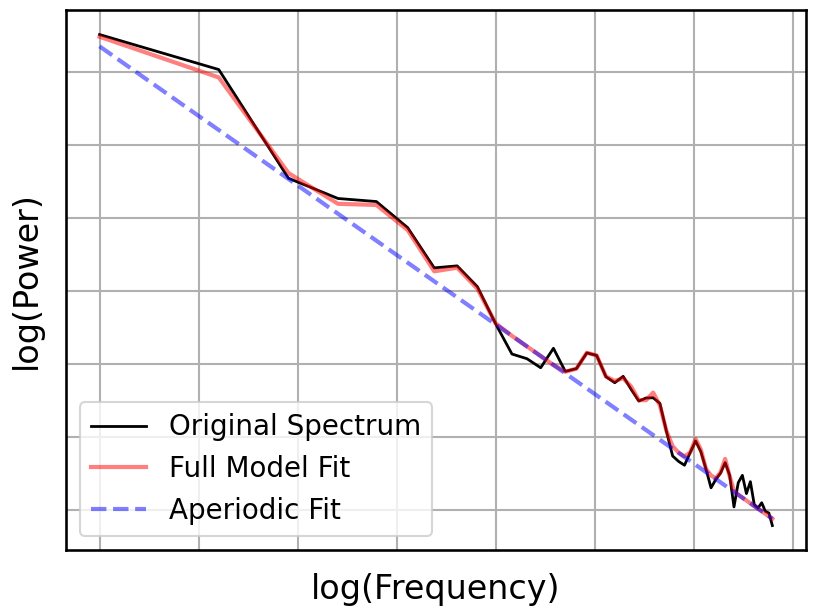

In [16]:
# Visualize aperiodic signal with spectral fit
fm.plot(**PSD_PLT_KWARGS, custom_styler=custom_psd_style_no_ticks, **fsaver('sp_example_ap'))

In [17]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 0.9514
Expected Exponent:	 -1.0000


#### Combined Signal

In [18]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(examples['combined'], FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [19]:
# Fit the spectral model
fm.fit(freqs, powers)

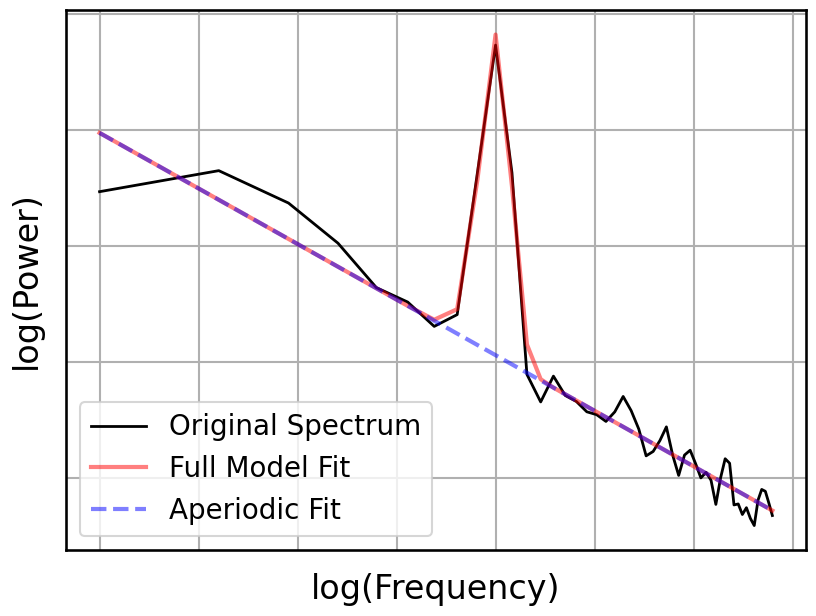

In [20]:
# Visualize combined signal with spectral fit
fm.plot(**PSD_PLT_KWARGS, custom_styler=custom_psd_style_no_ticks, **fsaver('sp_example_pe'))

In [21]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 0.9581
Expected Exponent:	 -1.0000


#### Knee Signal

In [22]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(examples['synaptic'], FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [23]:
# Fit the spectral model
fm.fit(freqs, powers)
fm_kn.fit(freqs, powers)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new


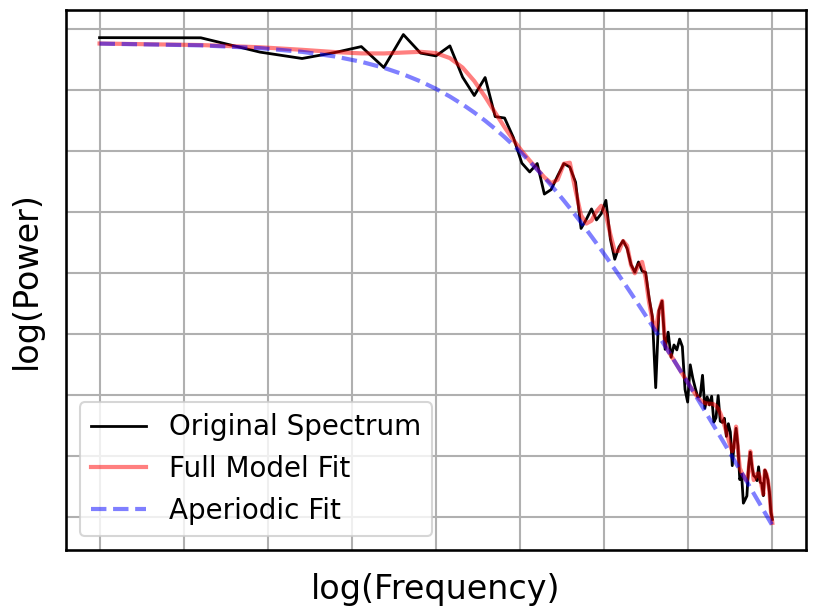

In [24]:
# Visualize knee signal with spectral fit
fm_kn.plot(**PSD_PLT_KWARGS, custom_styler=custom_psd_style_no_ticks, **fsaver('sp_example_knee'))

In [25]:
# Check the calculated value against ground truth
print('Measured Exponent (fixed):\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Measured Exponent (knee):\t {:1.4f}'.format(fm_kn.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t\t {:1.4f}'.format(2))

Measured Exponent (fixed):	 0.8965
Measured Exponent (knee):	 1.9538
Expected Exponent:		 2.0000


#### Peak Bandwidth

In [26]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(examples['comb_peak'], FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [27]:
# Fit the spectral model
fm.fit(freqs, powers)

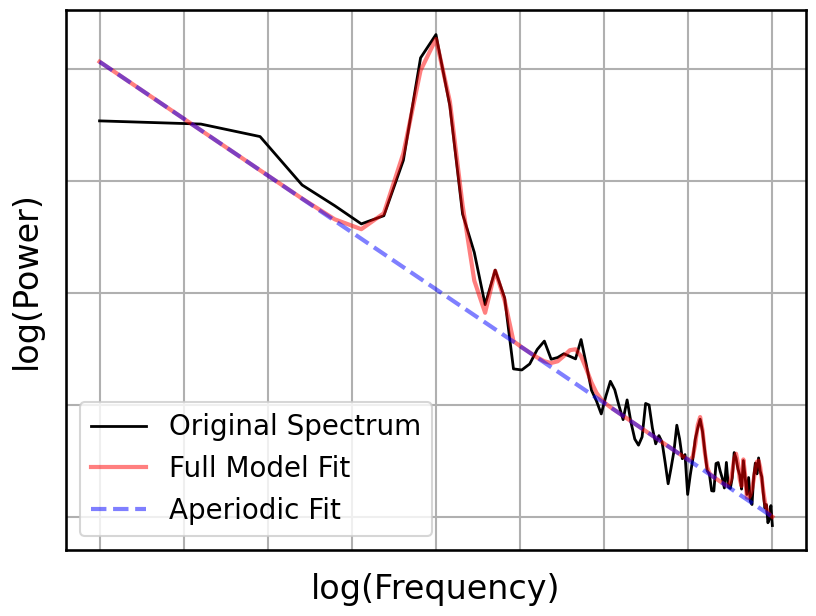

In [28]:
# Visualize peak bandwidth signal with spectral fit
fm.plot(**PSD_PLT_KWARGS, custom_styler=custom_psd_style_no_ticks, 
        #figsize=(8, 7),
        **fsaver('sp_example_bw'))

In [29]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 1.0155
Expected Exponent:	 -1.0000


## SPECPARAM Simulation Tests

### Simulations: Aperiodic Variations

#### Aperiodic Exponent

In [30]:
# Run simulations calculating specparam estimation across exponents
sp_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'], specparam, SPECPARAM_PARAMS, N_SIMS)

#### Aperiodic Exponent (combined signal)

In [31]:
# Run simulations calculating specparam exponent across exponents, with an oscillation
sp_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'], specparam, SPECPARAM_PARAMS, N_SIMS)

#### Visualize Results

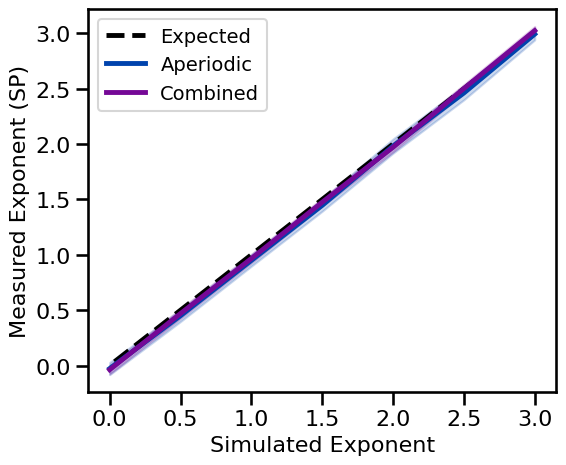

In [32]:
# Plot specparam exponent estimation across exponents, both with and without oscillation
plot_ap_sims(sp_sims_exp, sp_sims_comb, 'Measured Exponent (SP)',
             expected=np.abs(SIM_ITERS['ap_exp'].values), **fsaver('sp_ap'))

### Simulations: Periodic Variations

#### Oscillation Frequency

In [33]:
# Run simulations calculating specparam exponent across oscillation frequencies
sp_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'], specparam, SPECPARAM_PARAMS, N_SIMS)

#### Oscillation Power

In [34]:
# Run simulations calculating specparam exponent across oscillation power
sp_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'], specparam, SPECPARAM_PARAMS, N_SIMS)

#### Visualize Results

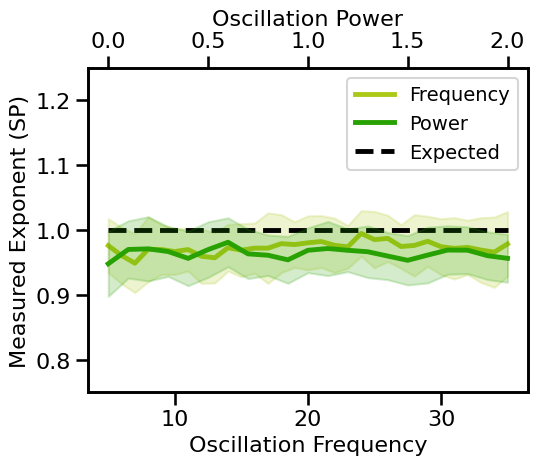

In [35]:
# Plot effect of oscillation variation on estimated exponent
plot_pe_sims(sp_sims_freq, sp_sims_pow, 'Measured Exponent (SP)',
             expected=[1.0]*len(SIM_ITERS['osc_freq']), ylim=[0.75, 1.25],
             **fsaver('sp_pe'))

## Simulations: Knee Variations

#### Without Knee Fit

In [36]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_tscales_lin = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'], 
                               specparam, SPECPARAM_PARAMS, N_SIMS)

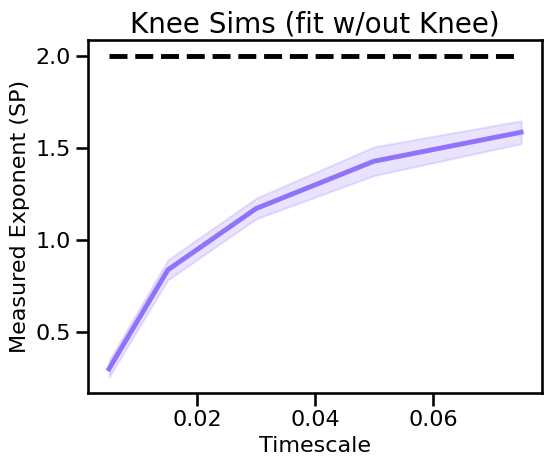

In [37]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_sims(SIM_ITERS['syn_tscales'].values, sp_sims_tscales_lin,
          'Timescale', 'Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['syn_tscales']),
          title='Knee Sims (fit w/out Knee)', **fsaver('sp_tscale_lin'))

In [38]:
# Run simulations calculating specparam exponent across knee parameters (sims from file)
sp_sims_knee_lin = run_sims_load('ap-knee-' + str(FS), specparam, SPECPARAM_PARAMS)

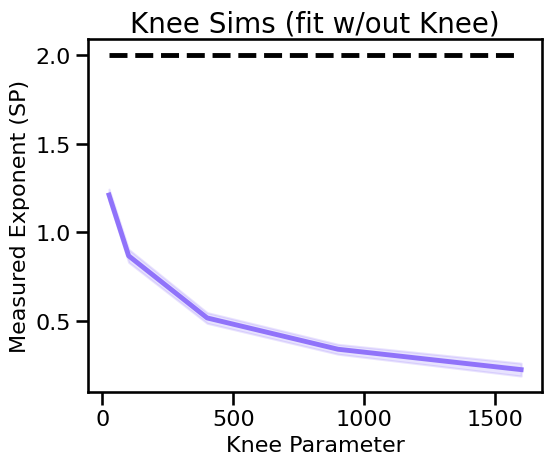

In [39]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_sims(SIM_ITERS['kn_knee'].values, sp_sims_knee_lin,
          'Knee Parameter', 'Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['kn_knee']),
          title='Knee Sims (fit w/out Knee)', **fsaver('sp_knee_lin'))

#### With Knee Fit

In [40]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_tscales = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'],
                           specparam, SPECPARAM_PARAMS_KNEE, N_SIMS)

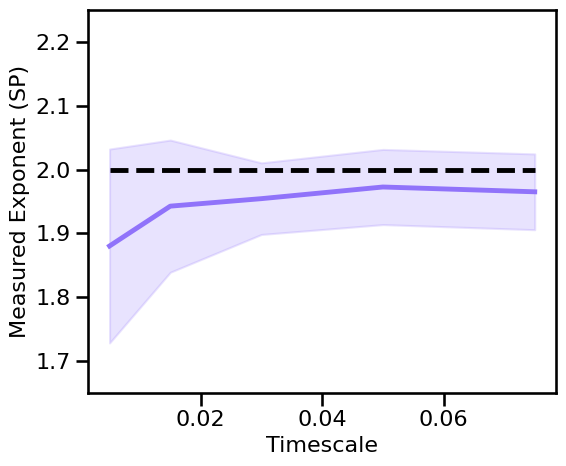

In [41]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_sims(SIM_ITERS['syn_tscales'].values, sp_sims_tscales,
          'Timescale', 'Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['syn_tscales']), ylim=[1.65, 2.25],
          **fsaver('sp_tscales'))

In [42]:
# Run simulations calculating specparam exponent across knee parameters (sims from file)
sp_sims_knee = run_sims_load('ap-knee-' + str(FS), specparam, SPECPARAM_PARAMS_KNEE)

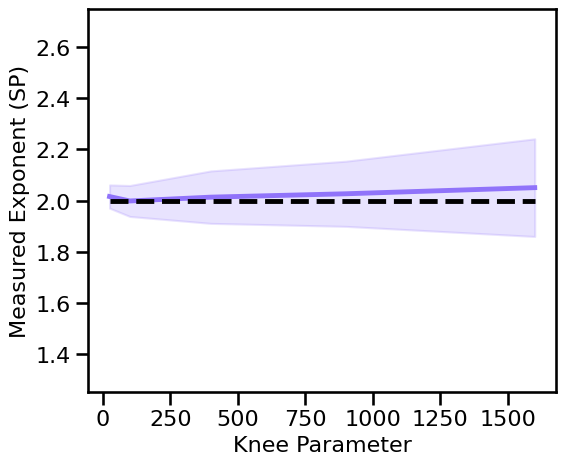

In [43]:
# Plot the estimated exponent across different knees (estimated with a knee)
plot_sims(SIM_ITERS['kn_knee'].values, sp_sims_knee,
          'Knee Parameter', 'Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['kn_knee']), ylim=[1.25, 2.75],
          **fsaver('sp_knee'))

## Simulations: Periodic Variations

In [44]:
# Run simulations calculating specparam exponent estimate across peak bandwidth (sims from file)
sp_sims_bw = run_sims_load('comb-bw-' + str(FS), specparam, SPECPARAM_PARAMS)

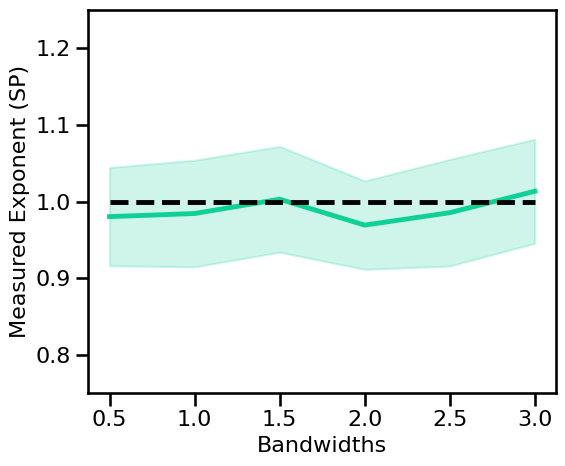

In [45]:
# Plot the estimated exponent across peak bandwidths
plot_sims(SIM_ITERS.iters['peak_bw'].values, sp_sims_bw,
          'Bandwidths', 'Measured Exponent (SP)', color=COLORS['BW'], ylim=[0.75, 1.25],
          expected=[-SIM_ITERS.params['ap']['exponent']] * len(SIM_ITERS.iters['peak_bw']),
          **fsaver('sp_bw'))

In [46]:
# Run simulations calculating specparam exponent across burst probabilities
sp_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'], specparam, SPECPARAM_PARAMS, N_SIMS)

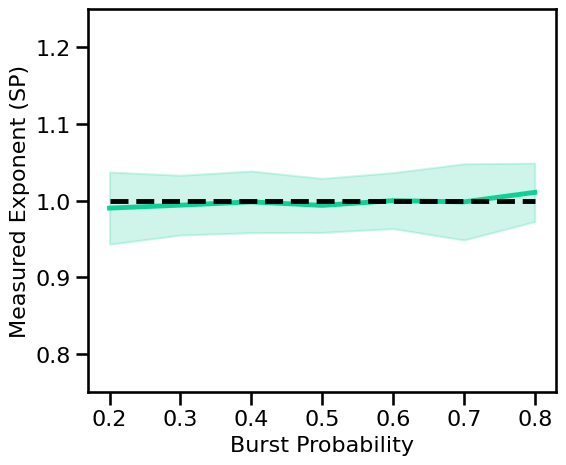

In [47]:
# Plot the estimated exponent across peak bandwidths
plot_sims(SIM_ITERS.iters['comb_burst'].values, sp_sims_burst,
          'Burst Probability', 'Measured Exponent (SP)', color=COLORS['BW'], ylim=[0.75, 1.25],
          expected=[-SIM_ITERS.params['ap']['exponent']] * len(SIM_ITERS.iters['comb_burst']),
          **fsaver('sp_burst'))

## Conclusions

Overall, we can see the following patterns in these simulations:
- Spectral parameterization is a robust estimator of the aperiodic exponent across multiple simulation parameters